In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
### https://blog.csdn.net/qq_29750461/article/details/81701240

In [9]:
df=pd.read_csv('combinedb_201912_final_20200122.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
data=df.groupby(['BU','Date'])['求和项:Volume'].sum().to_frame().reset_index()
BU_list=set(data['BU'].values)
data.rename(columns={'求和项:Volume':'volume'},inplace=True)

In [10]:
data_BU_SE=data[data['BU']=='BU_SE|东南区'].reset_index()
del data_BU_SE['index']
del data_BU_SE['BU']
data_BU_SE.index=pd.to_datetime(data_BU_SE['Date'],format='%Y-%m-%d')
del data_BU_SE['Date']

In [5]:
train=data_BU_SE[:int(len(data_BU_SE)/3*2)]
test=data_BU_SE[int(len(data_BU_SE)/3*2):]

## 自相关性和偏相关性图

In [13]:
def acf_and_pacf(train):
    data = train['volume'].values
    plot_acf(data)
    plot_pacf(data)
    plt.show()

## 判断时序数据稳定性

Test Statistic                -5.714789e+00
p-value                        7.162327e-07
#Lags Used                     8.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64

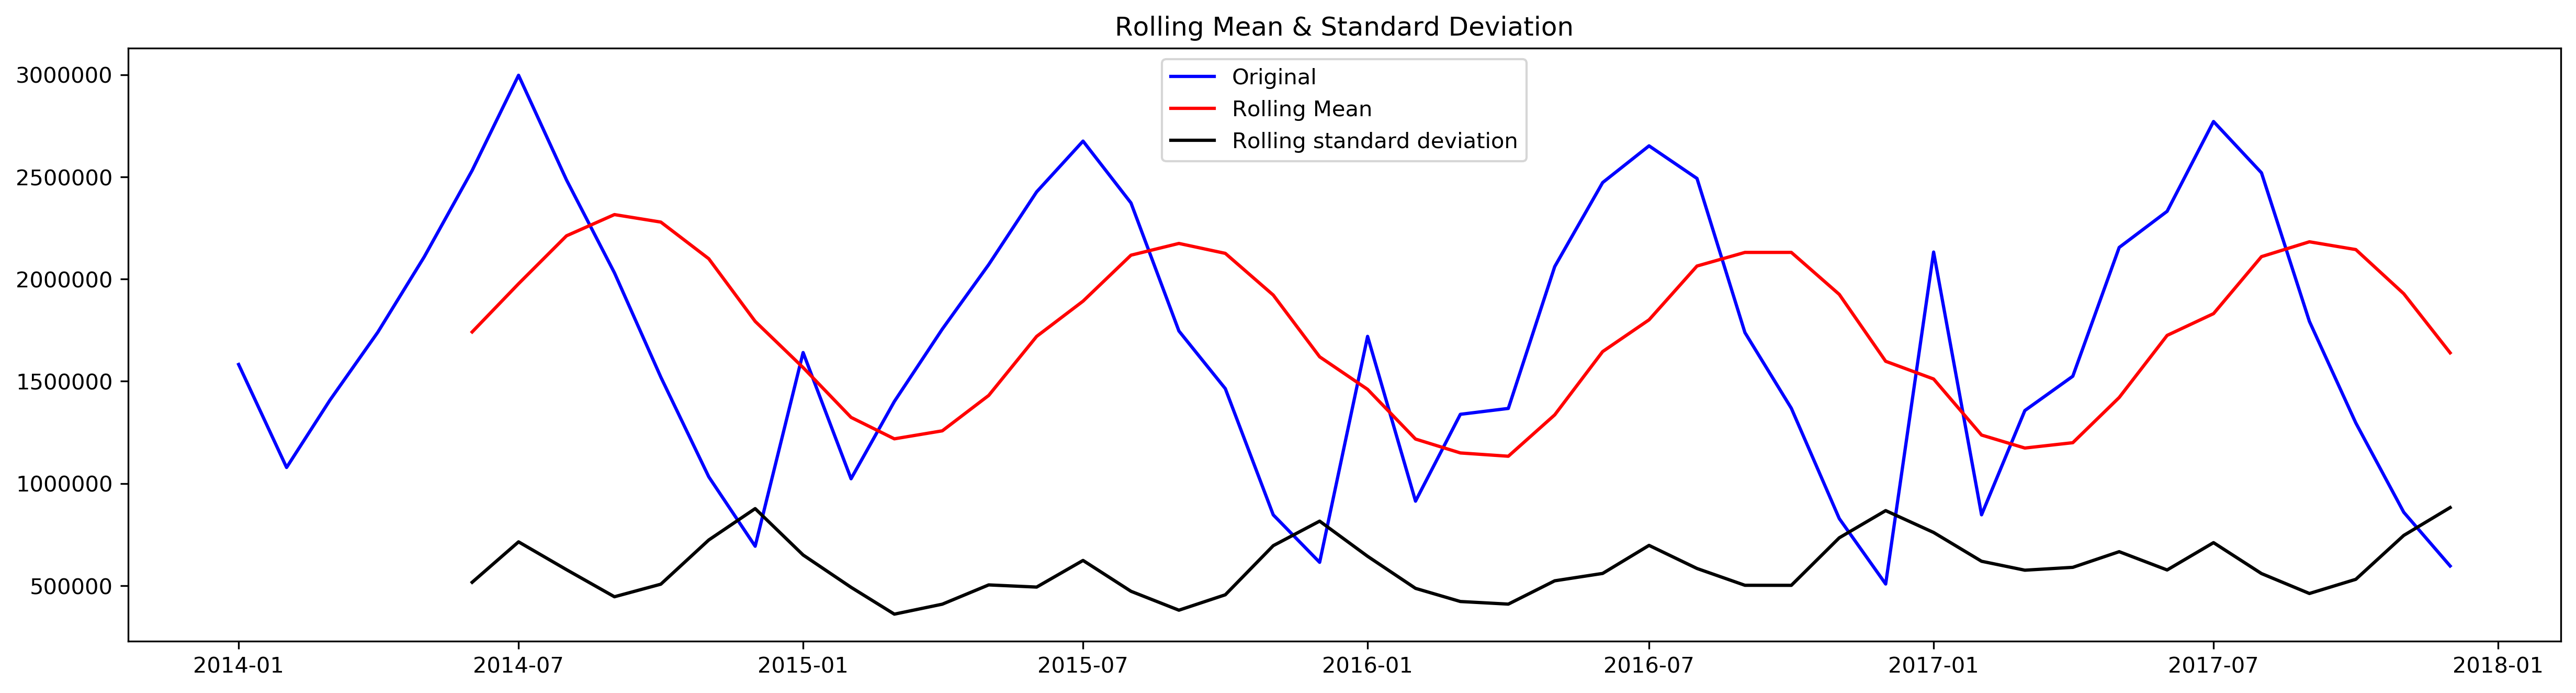

In [34]:
# 做平稳性检验:
# 指标：均值，方差，自协方差
# 方法：
# 方法一：计算每个时间段内的平均的数据均值和标准差
# 方法二： 单位根检验法：通过Dickey-Fuller Test 进行判断。它的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，
# 就需要在给定的置信水平上显著，拒绝原假设
def draw_trend(timeseries, size):
    fig,ax=plt.subplots(figsize=(20,5),dpi=300)
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()
    ax.plot(timeseries,color='blue', label='Original')
    ax.plot(rol_mean,color='red', label='Rolling Mean')
    ax.plot(rol_std,color='black', label='Rolling standard deviation')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation')
#     timeseries.plot(color='blue', label='Original')
#     rol_mean.plot(color='red', label='Rolling Mean')
#     rol_std.plot(color='black', label='Rolling standard deviation')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')

def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')

# Dickey-Fuller test:
def teststationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput
draw_trend(train,6)  # 12
teststationarity(train)  ## p-value<0.05 ->可以拒绝原假设-> 序列平稳

## 分解序列

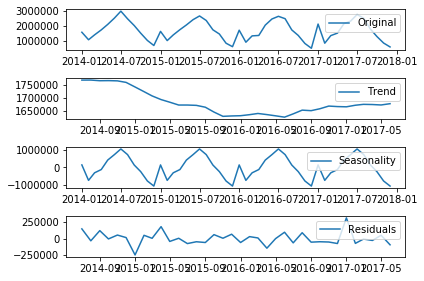

Test Statistic                -6.391097e+00
p-value                        2.104992e-08
#Lags Used                     5.000000e+00
Number of Observations Used    3.000000e+01
Critical Value (1%)           -3.669920e+00
Critical Value (5%)           -2.964071e+00
Critical Value (10%)          -2.621171e+00
dtype: float64

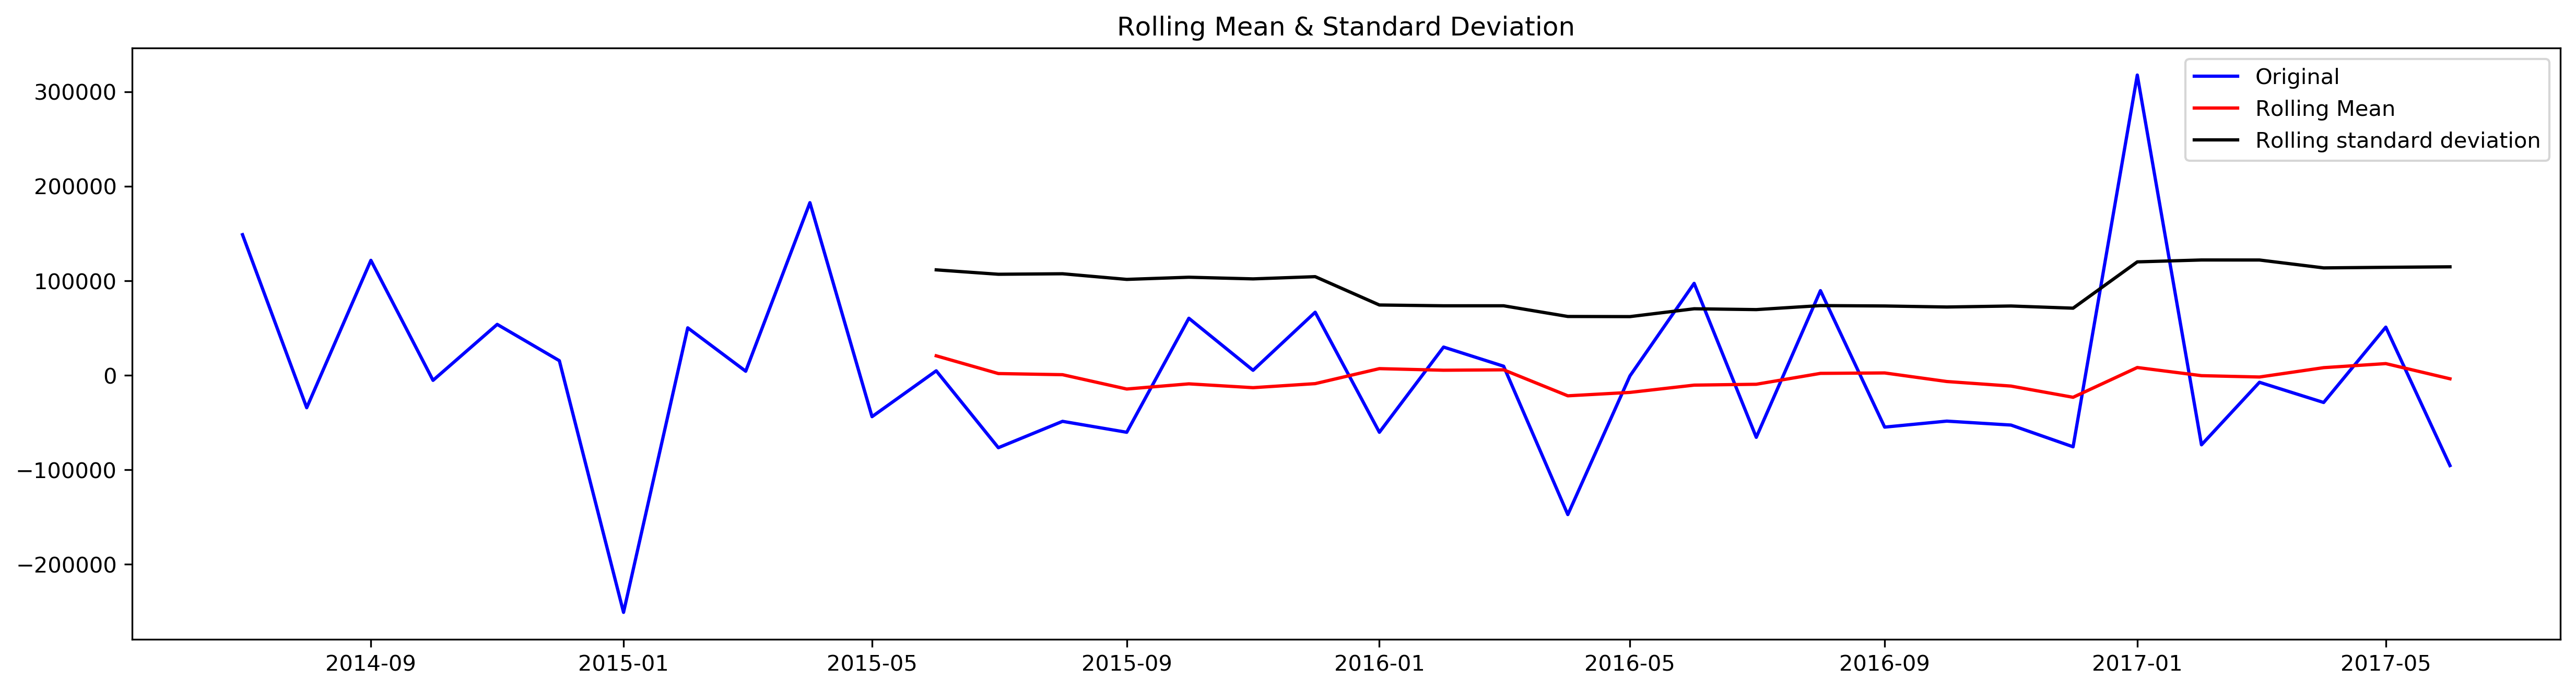

In [37]:
# 分解
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries):
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(train, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend , seasonal, residual
trend , seasonal, residual = decompose(train)
residual.dropna(inplace=True)
draw_trend(residual,12)
teststationarity(residual)

## 差分
1. 确定差分阶数 d
2. 确定p和q

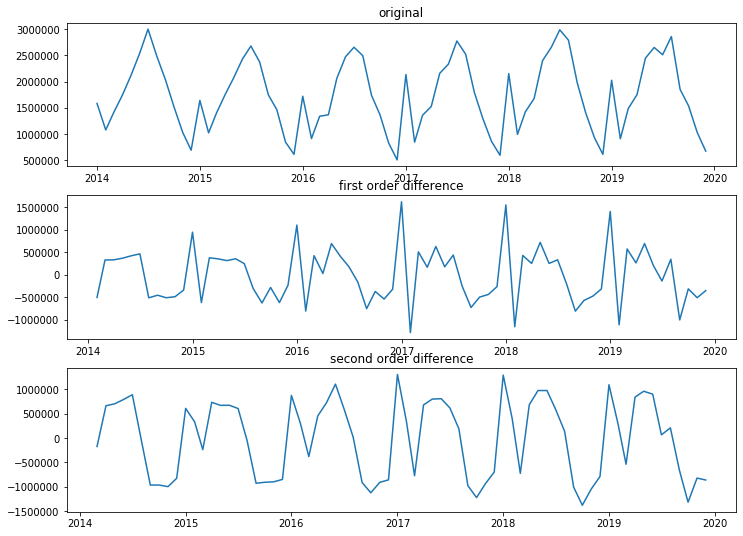

In [26]:
data=data_BU_SE.copy()
def difference(data):
    fig = plt.figure(figsize=(12,9))
    ax1,ax2,ax3=fig.subplots(3,1)
    ax1.plot(data)
    ax1.set_title('original')
    
    diff1=data.diff(1)
    ax2.plot(diff1)
    ax2.set_title('first order difference')
    
    diff2=data.diff(2)
    ax3.plot(diff2)
    ax3.set_title('second order difference')
    
difference(data)
## 决定差分阶数d

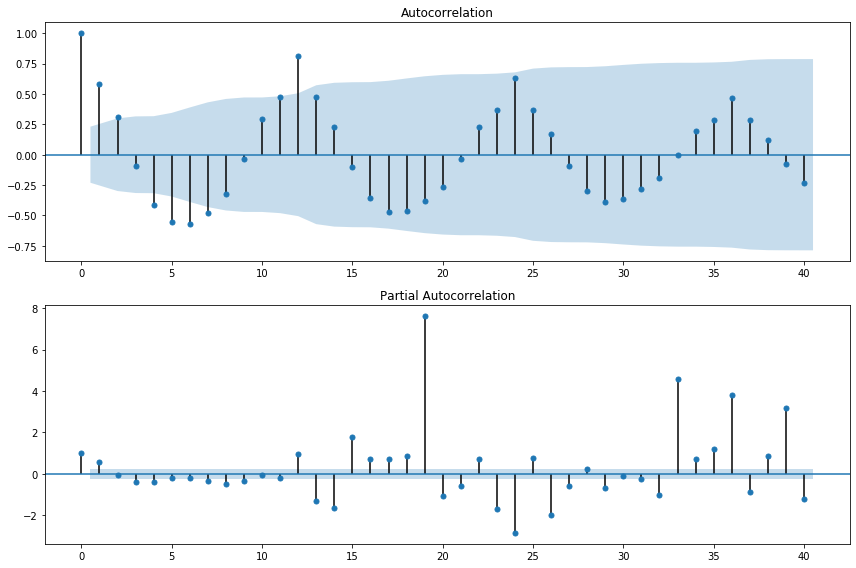

In [31]:
# 自相关图确定p和q
# p->partial autocorrelation->p阶后衰减趋向于0
# q->autocorrelation->q阶后衰减趋向于0
diff1=data.diff(1)
diff2=data.diff(2)
def acf_and_pacf(data):
    data = data['volume'].values
    fig = plt.figure(figsize=(12,8))
    
    ax1=fig.add_subplot(211)
    fig1=plot_acf(data,lags=40,ax=ax1)
    ax1.xaxis.set_ticks_position('bottom')
    fig1.tight_layout()
    
    ax2=fig.add_subplot(212)
    fig2=plot_pacf(data,lags=40,ax=ax2)
    ax2.xaxis.set_ticks_position('bottom')
    fig2.tight_layout();
acf_and_pacf(data)


In [38]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1,1,1)) 
result_arima = model.fit( disp=-1, method='css')

D:\Anoconda\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anoconda\envs\tf2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


NameError: name 'ts' is not defined

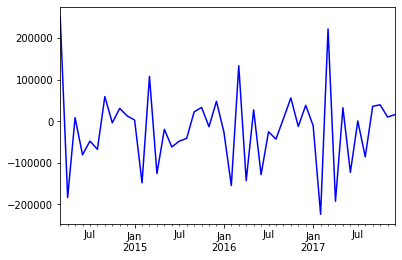

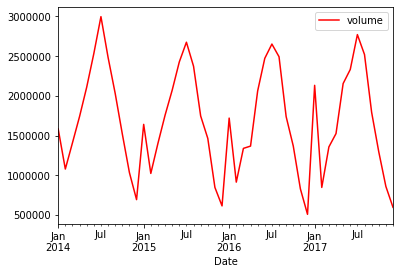

In [39]:
predict_ts = result_arima.predict()
ax
predict_ts.plot(color='blue', label='Predict')
train.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_ts-ts)**2)/predict_ts.size))

## ARIMA参数选择（grid search）
ARIMA(p, d, q)
在处理季节性影响时，我们利用季节性 ARIMA，表示为ARIMA(p,d,q)*(P,D,Q,S), S:季度为4，年为12
* 找AIC最小值

In [34]:
#找合适的p d q
#初始化 p d q
import itertools
p=d=q=range(0,2)
#产生不同的pdq元组,得到 p d q 全排列
pdq=list(itertools.product(p,d,q))
print("pdq:\n",pdq)
seasonal_pdq=[(x[0],x[1],x[2],12) for x in pdq]

pdq:
 [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
SQRIMAX:(0, 0, 1) x (0, 0, 1, 12)


In [37]:
import warnings
warnings.filterwarnings('ignore')
AICS=list()
paras=list()
for param in pdq:
    for indx,param_seasonal in enumerate(seasonal_pdq):
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if indx==0:
                min_AIC=results.aic
            else:
                if min_AIC>results.aic:
                    min_AIC=results.aic
                    target_param=param
                    target_param_seasonal=param_seasonal   
        except:
            continue
print('Best ARIMA{}x{}12 - AIC:{}'.format(target_param, target_param_seasonal, min_AIC))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2253.672334859097
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1836.8384666023549
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1580.7567319408945
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1261.0101260577692
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1607.3740571695294
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1573.7388917216579
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1287.5979353600758
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1260.5547957592105
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2181.2534395366656
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1793.9414485060784
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1552.8997924351631
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1235.1466389535328
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1845.8033880456676
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1786.429085233052
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1288.2083131861798
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1233.9653590153353
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2067.1929126204
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1681.81417667925

In [55]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0783      0.286     -0.274      0.784      -0.639       0.482
ma.L1         -0.7365      0.162     -4.544      0.000      -1.054      -0.419
ma.S.L12      -0.1250      0.203     -0.617      0.537      -0.522       0.272
sigma2      2.393e+10   1.44e-11   1.66e+21      0.000    2.39e+10    2.39e+10


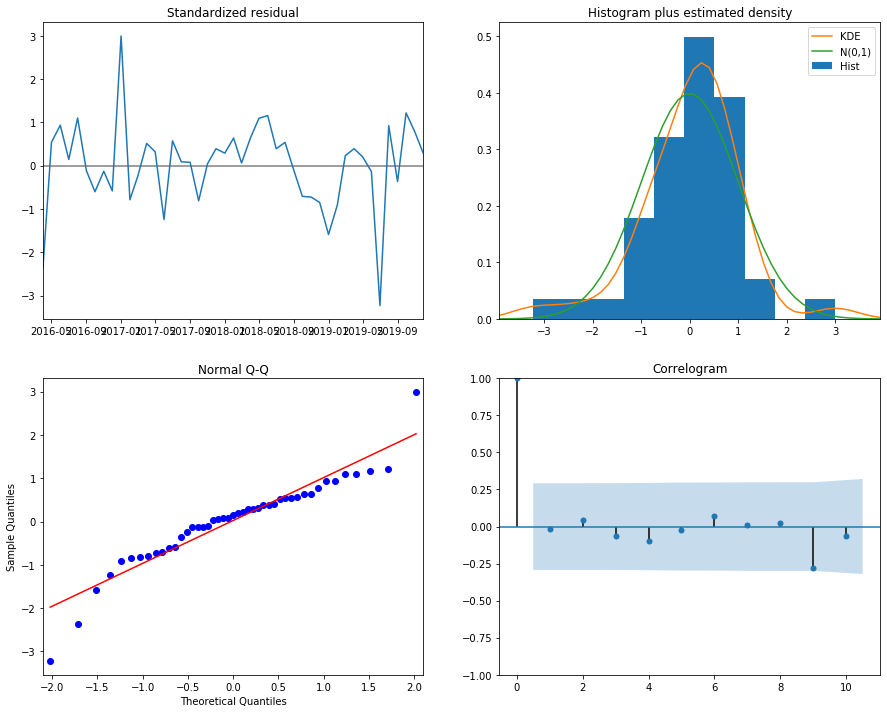

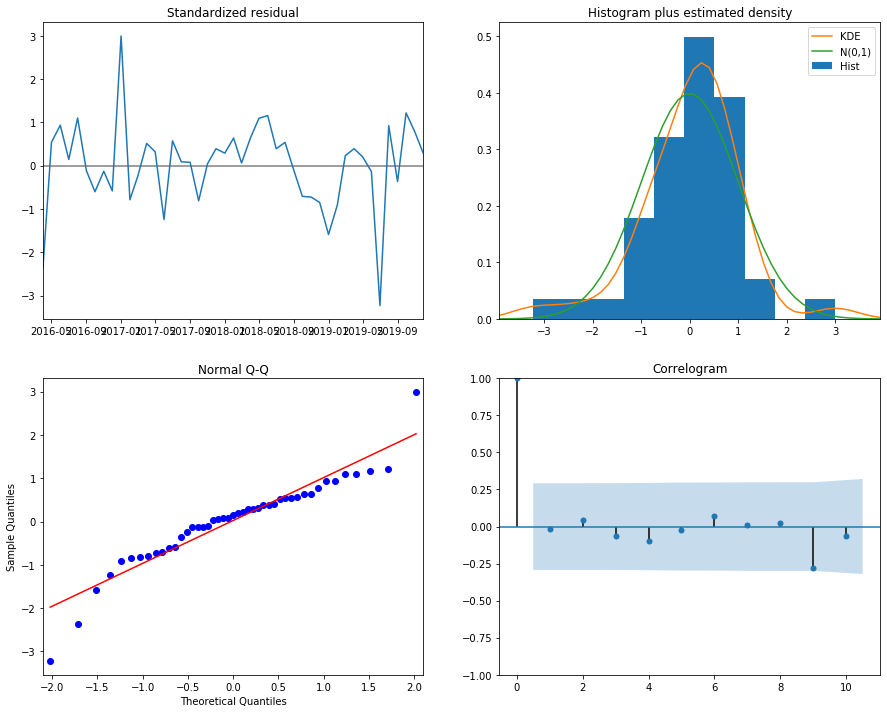

In [56]:
#在右上图中，我们看到红色KDE线与N(0,1)行（其中N(0,1) ）是正态分布的标准符号，平均值0 ，标准偏差为1 ） 。 这是残留物正常分布的良好指示。

#左下角的qq图显示，残差（蓝点）的有序分布遵循采用N(0, 1)的标准正态分布采样的线性趋势。 同样，这是残留物正常分布的强烈指示。

#随着时间的推移（左上图）的残差不会显示任何明显的季节性，似乎是白噪声。 这通过右下角的自相关（即相关图）来证实，这表明时间序列残差与其本身的滞后版本具有低相关性。
results.plot_diagnostics(figsize=(15, 12))

In [57]:
pred=results.get_prediction(start=pd.to_datetime('2018-01-01'),dynamic=False)
pred_ci=pred.conf_int()
print("pred ci:\n",pred_ci)#获得的是一个预测范围，置信区间
print("pred:\n",pred)#为一个预测对象
print("pred mean:\n",pred.predicted_mean)#为预测的平均值

pred ci:
             lower volume  upper volume
2018-01-01  1.801694e+06  2.408040e+06
2018-02-01  5.916529e+05  1.197999e+06
2018-03-01  1.111006e+06  1.717351e+06
2018-04-01  1.274367e+06  1.880713e+06
2018-05-01  1.924674e+06  2.531020e+06
2018-06-01  2.167656e+06  2.774002e+06
2018-07-01  2.619293e+06  3.225639e+06
2018-08-01  2.399179e+06  3.005525e+06
2018-09-01  1.689770e+06  2.296116e+06
2018-10-01  1.211942e+06  1.818288e+06
2018-11-01  7.396893e+05  1.346035e+06
2018-12-01  4.432674e+05  1.049613e+06
2019-01-01  1.965933e+06  2.572279e+06
2019-02-01  7.482968e+05  1.354643e+06
2019-03-01  1.145777e+06  1.752123e+06
2019-04-01  1.384745e+06  1.991091e+06
2019-05-01  2.108871e+06  2.715217e+06
2019-06-01  2.365429e+06  2.971775e+06
2019-07-01  2.705653e+06  3.311999e+06
2019-08-01  2.408716e+06  3.015061e+06
2019-09-01  1.604289e+06  2.210635e+06
2019-10-01  1.045848e+06  1.652194e+06
2019-11-01  6.044322e+05  1.210778e+06
2019-12-01  3.294134e+05  9.357591e+05
pred:
pred mean

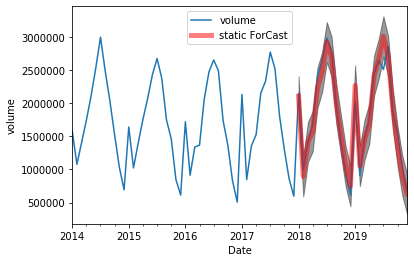

In [63]:
ax=data.plot(label="observed")
pred.predicted_mean.plot(ax=ax,label="static ForCast",alpha=.5,color='red',linewidth=5)
#在某个范围内进行填充
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('volume')
plt.legend()
plt.show()

In [82]:
y_forecasted=pred.predicted_mean
y_truth=data[48:]['volume']
mse=((y_forecasted-y_truth)**2).mean()
print("MSE:\n",mse)

MSE:
 22808776361.56869


In [43]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(ts_diff_1, order=(1,1,1)) 
result_arima = model.fit( disp=-1, method='css')

ModuleNotFoundError: No module named 'statsmodels.api.tsa'; 'statsmodels.api' is not a package

In [47]:
for param in pdq:
    mod = ARIMA(data,order=param)
    results = mod.fit()
    print('ARIMA{}- AIC:{}'.format(param, results.aic))
    if indx==0:
        min_AIC=results.aic
    else:
        if min_AIC>results.aic:
            min_AIC=results.aic
            target_param=param
print('Best ARIMA{}- AIC:{}'.format(target_param, min_AIC))

ARIMA(0, 0, 0)- AIC:2142.564141735972
ARIMA(0, 0, 1)- AIC:2123.781047993643
ARIMA(0, 1, 0)- AIC:2098.3194263479254
ARIMA(0, 1, 1)- AIC:2098.7155636919806
ARIMA(1, 0, 0)- AIC:2114.036534061905
ARIMA(1, 0, 1)- AIC:2143.7230227909777
ARIMA(1, 1, 0)- AIC:2098.2007381706903
ARIMA(1, 1, 1)- AIC:2099.0946469552896
Best ARIMA(1, 1, 1)- AIC:1210.447577783074


In [48]:
model=ARIMA(data,order=(1,1,1))
results = model.fit()
print(results.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.277e+04   6.37e+04     -0.200      0.841   -1.38e+05    1.12e+05
ar.L1.D.volume    -0.5929      0.310     -1.911      0.056      -1.201       0.015
ma.L1.D.volume     0.4203      0.343      1.224      0.221      -0.253       1.094


In [51]:
help(model)

Help on ARIMA in module statsmodels.tsa.arima_model object:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 

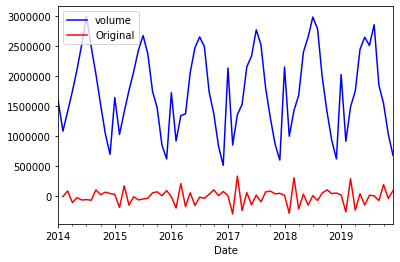

In [53]:
predict_ts = results.predict()
# # 一阶差分还原
# diff_shift_ts = ts_diff_1.shift(1)
# diff_recover_1 = predict_ts.add(diff_shift_ts)
data.plot(color='blue', label='Predict')
predict_ts.plot(color='red', label='Original')
plt.legend(loc='best')
#plt.title('RMSE: %.4f'% np.sqrt(sum((data-predict_ts)**2)/predict_ts.size))
plt.show()

In [54]:
predict_ts.plot_diagnostics(figsize=(15, 12))

AttributeError: 'Series' object has no attribute 'plot_diagnostics'